In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates

from teslakit.plotting.climate_emulator import Plot_Simulation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

WVS = db.Load_WAVES_hist()      # Historical gow waves point
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db.Load_ESTELA_DWT_sim()

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])



## Climate Emulator - Complete Output

In [4]:
# --------------------------------------
# Climate Emulator extremes model 

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# Load Climate Emulator simulations
WVS_sim, TCs_sim, WVS_upd = CE.LoadSim()

print(WVS_upd)

<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 98926)
Coordinates:
  * time         (time) object 1700-01-01 00:00:00 ... 2700-01-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    DWT          (n_sim, time) float32 ...
    sea_Hs       (n_sim, time) float32 ...
    sea_Tp       (n_sim, time) float32 ...
    sea_Dir      (n_sim, time) float32 ...
    swell_1_Hs   (n_sim, time) float32 ...
    swell_1_Tp   (n_sim, time) float32 ...
    swell_1_Dir  (n_sim, time) float32 ...
    swell_2_Hs   (n_sim, time) float32 ...
    swell_2_Tp   (n_sim, time) float32 ...
    swell_2_Dir  (n_sim, time) float32 ...


In [5]:
# --------------------------------------
#  Generate hourly waves data from storms 

def Simulation_Hourly(wvs_sim, tcs_sim):
    '''
    Generate hourly simulation output. 
    
    - aggregate simulated waves storms
    - generate hourly hydrographs
    - calculates AWL
    '''
    
    # iterate simulations
    ls_hy = []
    for i_sim in wvs_sim.n_sim:
        
        # Aggregate waves families
        wvs_agr = Aggregate_WavesFamilies(wvs_sim.sel(n_sim=i_sim))

        # Calculate Intradaily hourly hydrographs for simulated storms
        hy = Intradaily_Hydrograph(wvs_agr, tcs_sim.sel(n_sim=i_sim))
        ls_hy.append(hy)
        
    # combine hourly simulations
    hy = xr.concat(ls_hy, 'n_sim')

    # Calculate hourly Atmospheric Water Level and Total Water Level
    hy['AWL'] = AWL(hy.Hs, hy.Tp)

    return hy
    
    
# Generate simulated hourly data using intradaily hydrographs
WVS_sim_h = Simulation_Hourly(WVS_upd, TCs_sim)  
print(WVS_sim_h)
  
# Store hourly waves simulations
db.Save_SIM_Waves(WVS_sim_h)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765809)
Coordinates:
  * time     (time) object 1700-01-01 1700-01-01T01:00:00 ... 2700-01-01
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 2.837 2.818 2.799 2.78 ... 1.347 1.347 1.347
    Tp       (n_sim, time) float32 11.03366 11.03366 ... 10.414267 9.06516
    Dir      (n_sim, time) float32 nan nan nan nan nan ... nan nan nan nan nan
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_sim, time) float64 0.7985 0.7958 0.7931 ... 0.5194 0.5194 0.4521


In [6]:
# --------------------------------------
# Get all simulated data (hourly): AWTs, DWTs, MJO, MMSL, AT

# TODO Load_SIM_Covariates regenerate=True fails: times dtypes
CVS_sim_h = db.Load_SIM_Covariates(n_sim_awt=0, n_sim_mjo=0, n_sim_dwt=0, regenerate=False)

# Load simulated waves
WVS_sim_h = db.Load_SIM_Waves()

# Complete simulation output 
d1, d2 = xds_limit_dates([WVS_sim_h, CVS_sim_h])
WVS_sim_h = WVS_sim_h.sel(time = slice(d1, d2))
CVS_sim_h = CVS_sim_h.sel(time = slice(d1, d2))

SIM_COMPLETE = xr.merge([WVS_sim_h, CVS_sim_h])

# calculate TWL
SIM_COMPLETE['TWL'] = SIM_COMPLETE['AWL'] + SIM_COMPLETE['SS'] + SIM_COMPLETE['AT'] + SIM_COMPLETE['MMSL']
print(SIM_COMPLETE)

# Store complete simulations
db.Save_SIM_Complete(SIM_COMPLETE)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765809)
Coordinates:
  * time     (time) object 1700-01-01 00:00:00 ... 2700-01-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float32 ...
    Tp       (n_sim, time) float32 ...
    Dir      (n_sim, time) float32 ...
    SS       (n_sim, time) float32 ...
    AWL      (n_sim, time) float32 ...
    AWT      (time) float32 ...
    MJO      (time) float32 ...
    DWT      (time) float32 ...
    MMSL     (time) float32 ...
    AT       (time) float32 ...
    TWL      (n_sim, time) float32 0.14977007 0.27285424 ... 0.7385291 0.6221881


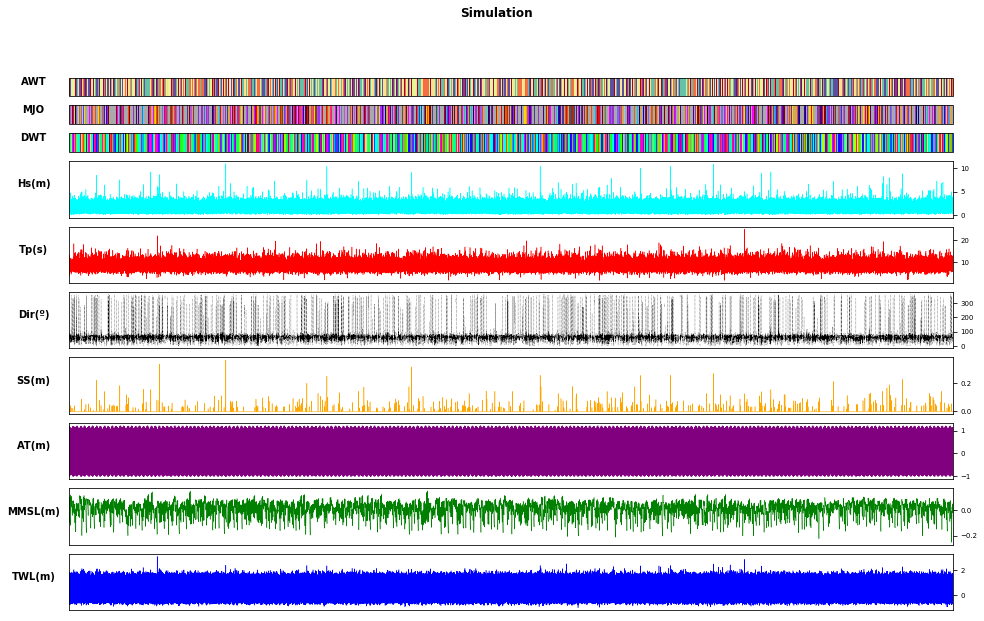

In [7]:
# Plot Simulation 
SIM = db.Load_SIM_Complete()

Plot_Simulation(SIM_COMPLETE.sel(n_sim=0));
